<a href="https://colab.research.google.com/github/emmethalm/youtube-to-chatbot/blob/main/YouTube_to_chatbot_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 👉 [Original launch announcement](https://twitter.com/ehalm_/status/1660914850107883520?s=20) 🚀

# YouTube-to-Chatbot

Train a chatbot on an entire YouTube channel.

This notebook uses YouTube, OpenAI, Langchain, and Pinecone to build a conversational agent trained to mimic the content, knowledge, and tone of a YouTube channel.

Simply add in the YouTube ID of the channel you'd like to clone, add your API keys (OpenAI, YouTube, Pinecone), and run each step of the notebook. My hope is that this project unlocks more values for creators & helps grow communities.

## To get early access to new features, follow [@ehalm_](https://twitter.com/ehalm_) on Twitter. If you're a creator looking for a custom model or a developer wanting to contribute, DM me :)

-
Emmet ✌

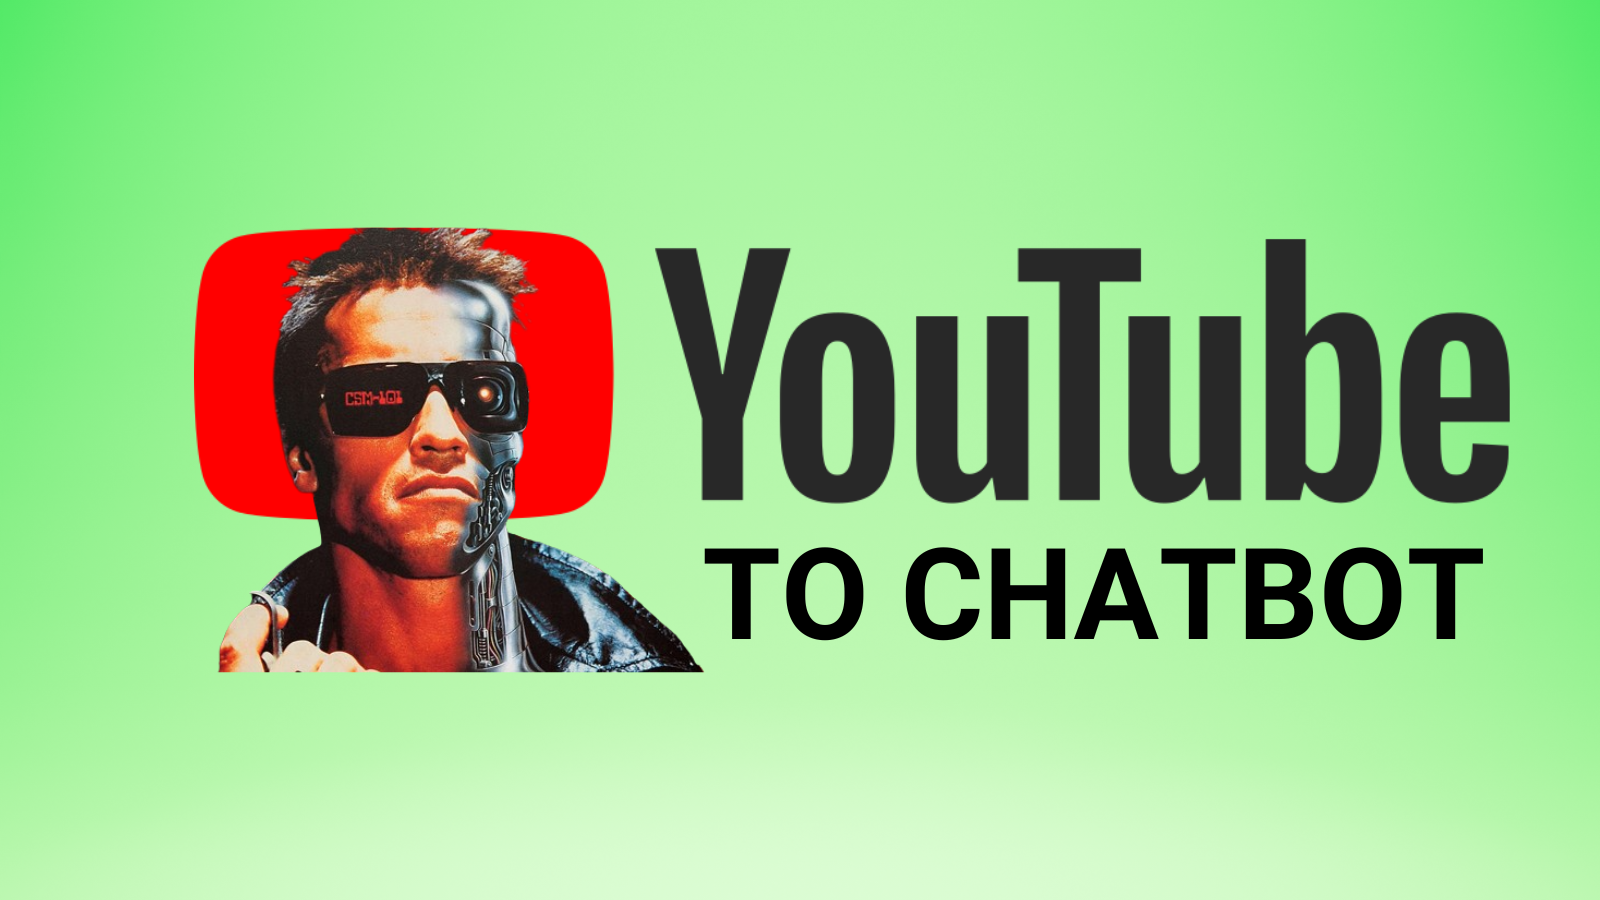


## Install dependencies

In [ ]:
!pip install -qU \
    openai==0.27.7 \
    pinecone-client[grpc]==2.2.1 \
    langchain==0.0.162 \
    tiktoken==0.4.0 \
    datasets==2.12.0 \
    youtube_transcript_api 

# Scrape an entire YouTube channel into one .txt file

In [ ]:
api_key = "" #@param {type:"string"}
channel_id = "" #@param {type:"string"} # Get your channel ID here https://commentpicker.com/youtube-channel-id.php

def get_channel_videos(channel_id, api_key):
    youtube = googleapiclient.discovery.build(
        "youtube", "v3", developerKey=api_key)

    video_ids = []
    page_token = None

    while True:
        request = youtube.search().list(
            part="snippet",
            channelId=channel_id,
            maxResults=50,  # Fetch 50 videos at a time
            pageToken=page_token  # Add pagination
        )
        response = request.execute()

        video_ids += [item['id']['videoId'] for item in response['items'] if item['id']['kind'] == 'youtube#video']
        
        # Check if there are more videos to fetch
        if 'nextPageToken' in response:
            page_token = response['nextPageToken']
        else:
            break

    return video_ids

def get_transcripts(video_ids):
    transcripts = []
    for video_id in tqdm(video_ids):
        try:
            transcript = YouTubeTranscriptApi.get_transcript(video_id)
            transcripts.append(transcript)
        except Exception as ex:
            print(f"An error occurred for video: {video_id} [{ex}]")
    return transcripts

def write_to_file(transcripts):
    with open('YouTube.txt', 'w') as f:
        for transcript in transcripts:
            for item in transcript:
                f.write(item['text'] + '\n')

def main(api_key, channel_id):
    video_ids = get_channel_videos(channel_id, api_key)[:20]
    transcripts = get_transcripts(video_ids)
    print(transcripts)
    write_to_file(transcripts)

main(api_key, channel_id)

### Run our text file through infiniteGPT to clean its grammar and punctuation.

In [ ]:
YOUR_OPENAI_API_KEY = "" #@param {type:"string"}
import openai
from langchain.chat_models.openai import ChatOpenAI
from concurrent.futures import ThreadPoolExecutor
import tiktoken
from pathlib import Path
from langchain.schema import (
    HumanMessage,
    SystemMessage
)

chat = ChatOpenAI(model="gpt-3.5-turbo",temperature=0.2,max_tokens=500)

openai.api_key = YOUR_OPENAI_API_KEY

def load_text(file_path):
    with Path(file_path).open("r") as file:
        return file.read()

def save_to_file(responses, output_file):
    with Path(output_file).open('w') as file:
        file.write("\n".join(responses))

def call_openai_api(chunk):
    messages = [
        SystemMessage(content="Clean the following transcripts of all gramatical mistakes, misplaced words, and identify the speakers."),
        HumanMessage(content=chunk)
    ]
    response = chat(messages)
    return response.content.strip()

def split_into_chunks(text, n_tokens=300):
    encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')
    tokens = encoding.encode(text)
    chunks = []
    for i in range(0, len(tokens), n_tokens):
        chunks.append(' '.join(encoding.decode(tokens[i:i + n_tokens])))
    return chunks   

def process_chunks(input_file, output_file, delay=0):  # delay in seconds (if you hit a rate limit error)
    text = load_text(input_file)
    chunks = split_into_chunks(text)[:5]
    responses = []
    for chunk in tqdm(chunks):
        responses.append(call_openai_api(chunk))

    save_to_file(responses, output_file)

    # Specify your input and output files

if __name__ == "__main__":
    input_file = "YouTube.txt"
    output_file = "clean_transcript.txt"
    process_chunks(input_file, output_file)

    # Can take up to a few minutes to run depending on the size of your data input

## Building the Knowledge Base

We start by constructing our knowledge base. Make sure to input the correct .txt file. For most users, this will be your cleaned_transcript.txt file.

In [ ]:
import pandas as pd

# Read the .txt file into Python
with Path('clean_transcript.txt').open('r') as file:
    lines = file.read().splitlines()

# Group the lines into chunks of 5
chunks = [' '.join(lines[i:i+5]) for i in range(0, len(lines), 5)]

# Convert list of chunks into a DataFrame
data = pd.DataFrame(chunks, columns=['context'])

# Add an index column and a name column
data['name'] = 'youtube'

# Remove duplicates (if any)
data.drop_duplicates(subset='context', keep='first', inplace=True)

print(data)

### Initialize the Embedding Model and Vector DB

We'll be using OpenAI's `text-embedding-ada-002` model initialize via LangChain and the Pinecone vector DB. We start by initializing the embedding model, for this we need an [OpenAI API key](https://platform.openai.com/).

*(Note that OpenAI is a paid service and so running the remainder of this notebook will cost a few dimes)*

In [ ]:
from getpass import getpass
from langchain.embeddings.openai import OpenAIEmbeddings

OPENAI_API_KEY = getpass("OpenAI API Key: ")  # platform.openai.com
model_name = 'text-embedding-ada-002'

embed = OpenAIEmbeddings(
    model=model_name,
    openai_api_key=OPENAI_API_KEY
)

Next we initialize the vector database. For this we need a [free API key](https://app.pinecone.io/), then we create the index:

In [ ]:
 import pinecone

# find API key in console at app.pinecone.io

YOUR_API_KEY = '' #@param {type:"string"}
# find ENV (cloud region) next to API key in console
YOUR_ENV = '' #@param {type:"string"}

index_name = 'youtube-chatbot-agent'
pinecone.init(
    api_key=YOUR_API_KEY,
    environment=YOUR_ENV
)

if index_name not in pinecone.list_indexes():
    # we create a new index
    pinecone.create_index(
        name=index_name,
        metric='dotproduct',
        dimension=1536  # 1536 dim of text-embedding-ada-002
    )

Then connect to the index:

In [ ]:
index = pinecone.GRPCIndex(index_name)
index.describe_index_stats()

We should see that the new Pinecone index has a `total_vector_count` of `0`, as we haven't added any vectors yet.

## Indexing

We can perform the indexing task using the Pinecone python client directly. We will do this in batches of `100` or more.

In [ ]:
from tqdm.auto import tqdm
from uuid import uuid4

# Reset index and ensure 'index' column is added
data = data.reset_index(drop=True)
data = data.reset_index()

batch_size = 100

for i in tqdm(range(0, len(data), batch_size)):
    # get end of batch
    i_end = min(len(data), i+batch_size)
    batch = data.iloc[i:i_end]
    
    # first get metadata fields for this record
    metadatas = [{
      'text': record[0],  # 'text' will contain the same data as 'context'
      'name': record[1]
    } for record in batch.itertuples(index=False)]
    
    # get the list of contexts / documents
    documents = batch['context'].tolist()
    
    # create document embeddings
    embeds = embed.embed_documents(documents)
    
    # get IDs and convert them to strings
    ids = batch['index'].astype(str).tolist()
    
    # add everything to pinecone
    index.upsert(vectors=list(zip(ids, embeds, metadatas)))


  0%|          | 0/9 [00:00<?, ?it/s]

We've indexed everything, now we can check the number of vectors in our index like so:

In [ ]:
index.describe_index_stats()

## Creating a Vector Store and Querying

Now that we've build our index we can switch back over to LangChain. We start by initializing a vector store using the same index we just built. We do that like so:

In [ ]:
from langchain.vectorstores import Pinecone

text_field = "text"

# switch back to normal index for langchain
index = pinecone.Index(index_name)

vectorstore = Pinecone(
    index, embed.embed_query, text_field
)

As in previous examples, we can use the `similarity_search` method to do a pure semantic search (without the generation component).

In [ ]:
query = "how to make viral videos?"

vectorstore.similarity_search(
    query,  # our search query
    k=3  # return 3 most relevant docs
)

Looks like we're getting good results. Let's take a look at how we can begin integrating this into a conversational agent.

## Initializing the Conversational Agent

Our conversational agent needs a Chat LLM, conversational memory, and a `RetrievalQA` chain to initialize. We create these using:

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.chains import RetrievalQA

# chat completion llm
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name='gpt-3.5-turbo',
    temperature=0.0
)
# conversational memory
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)
# retrieval qa chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever()
)

Using these we can generate an answer using the `run` method:

In [ ]:
qa.run(query)

But this isn't yet ready for our conversational agent. For that we need to convert this retrieval chain into a tool. We do that like so:

In [ ]:
from langchain.agents import Tool

tools = [
    Tool(
        name='Knowledge Base',
        func=qa.run,
        description=(
            'use this tool for every query to get '
            'more information and stories on the topic'
        )
    )
]

Now we can initialize the agent like so:

In [ ]:
from langchain.agents import initialize_agent

agent = initialize_agent(
    agent='chat-conversational-react-description',
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
    memory=conversational_memory
)

With that our retrieval augmented conversational agent is ready and we can begin using it. For better results, make the sys_msg description as specific and elaborate as possible.

In [ ]:
agent.agent.llm_chain.prompt

In [ ]:
sys_msg = """You are [NAME], a [description] & content creator. You are an expert in [description]. Answer the user's questions with [desired tone].
"""

prompt = agent.agent.create_prompt(
    system_message=sys_msg,
    tools=tools
)
agent.agent.llm_chain.prompt = prompt

In [ ]:
agent.agent.llm_chain.prompt

### Using the Conversational Agent

To make queries we simply call the `agent` directly.

In [ ]:
agent("Tell me about yourself")

We're also able to ask questions that refer to previous interactions in the conversation and the agent is able to refer to the conversation history to as a source of information.

Once finished, delete the Pinecone index to save resources:

In [ ]:
pinecone.delete_index(index_name)

---